linear regression model (train, Make Predictions, evaluate and Visualize Results)

 Tải dữ liệu thành công!

 Huấn luyện mô hình: Linear Regression ...
 Hoàn tất huấn luyện Linear Regression!

--- Hiệu suất (dev set) (Linear Regression) ---
  MAE:   1.9911
  MSE:   6.4840
  RMSE:  2.5464
  R²:    0.7505


 Huấn luyện mô hình: Random Forest ...


c:\Users\lenovo\miniconda3\envs\ml_env\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


 Hoàn tất huấn luyện Random Forest!

--- Hiệu suất (dev set) (Random Forest) ---
  MAE:   2.1149
  MSE:   7.4971
  RMSE:  2.7381
  R²:    0.7115


 Huấn luyện mô hình: XGBoost ...
 Hoàn tất huấn luyện XGBoost!

--- Hiệu suất (dev set) (XGBoost) ---
  MAE:   2.1099
  MSE:   7.7476
  RMSE:  2.7834
  R²:    0.7019


 Đang tạo biểu đồ trực quan hóa số với dự đoán (dev set)...


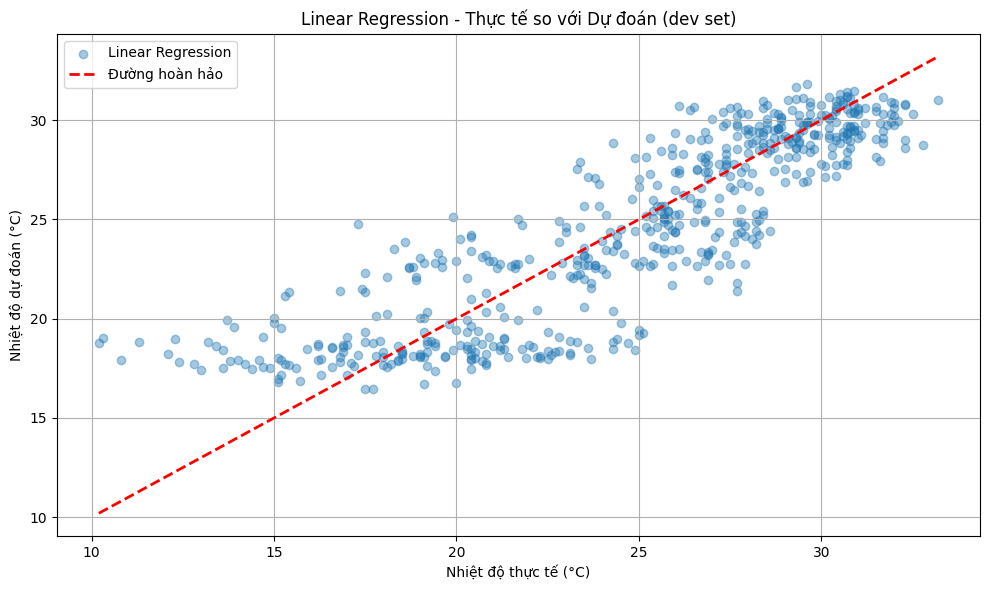

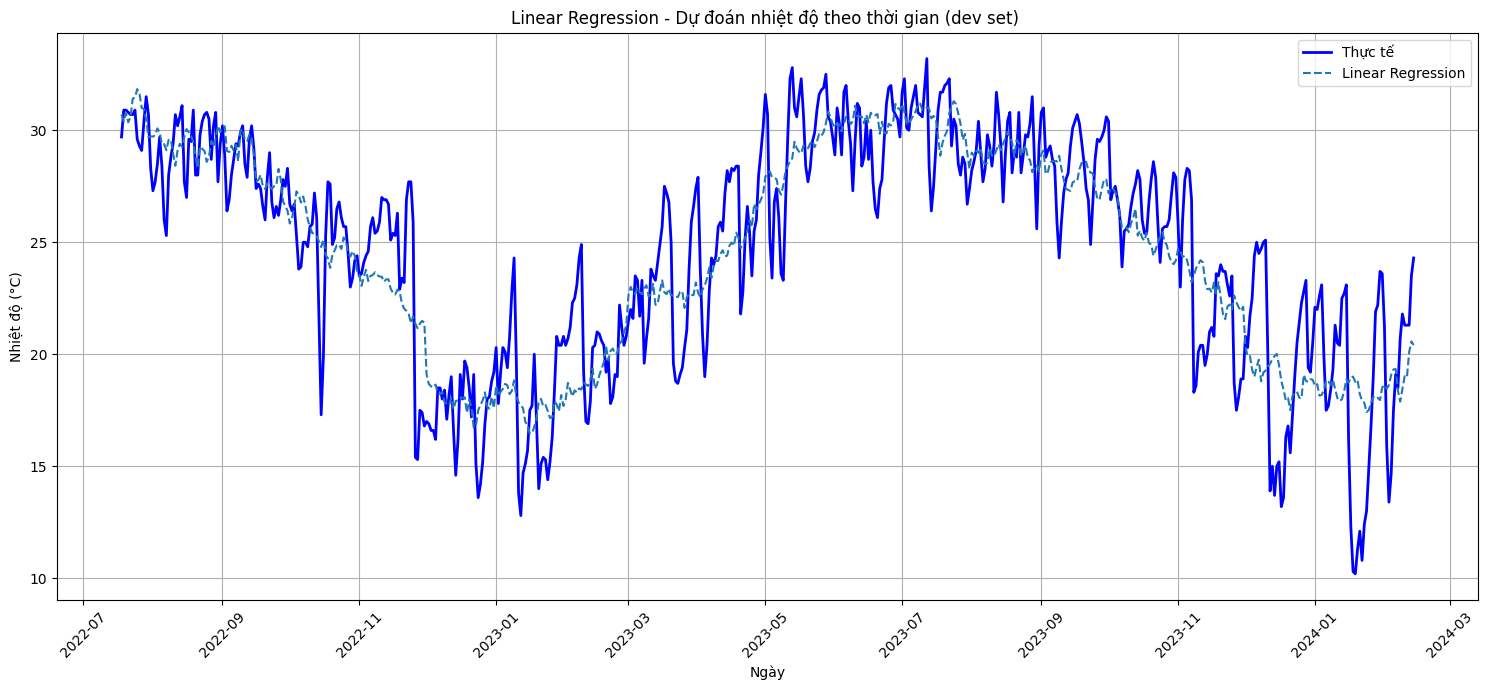

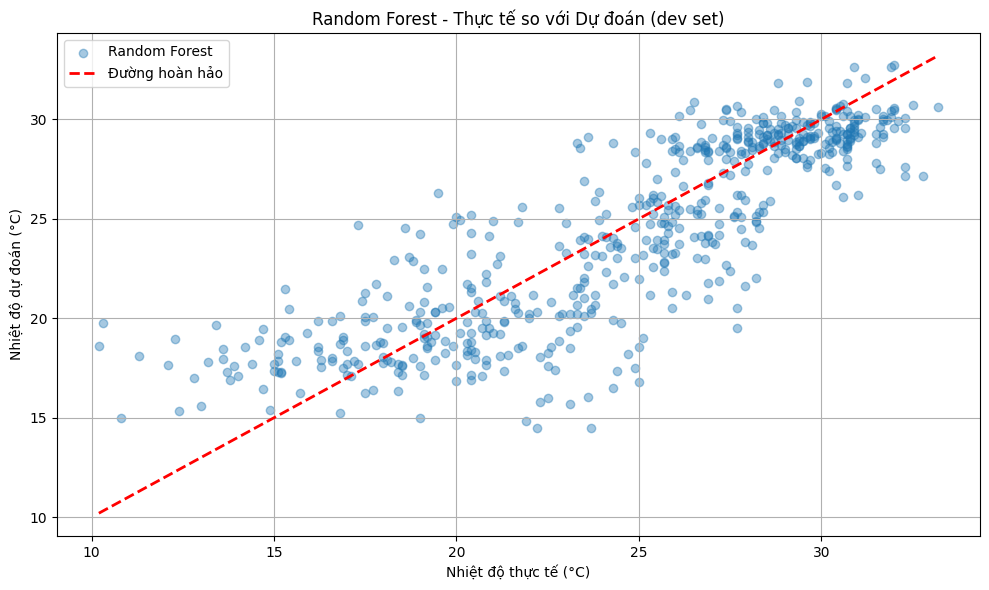

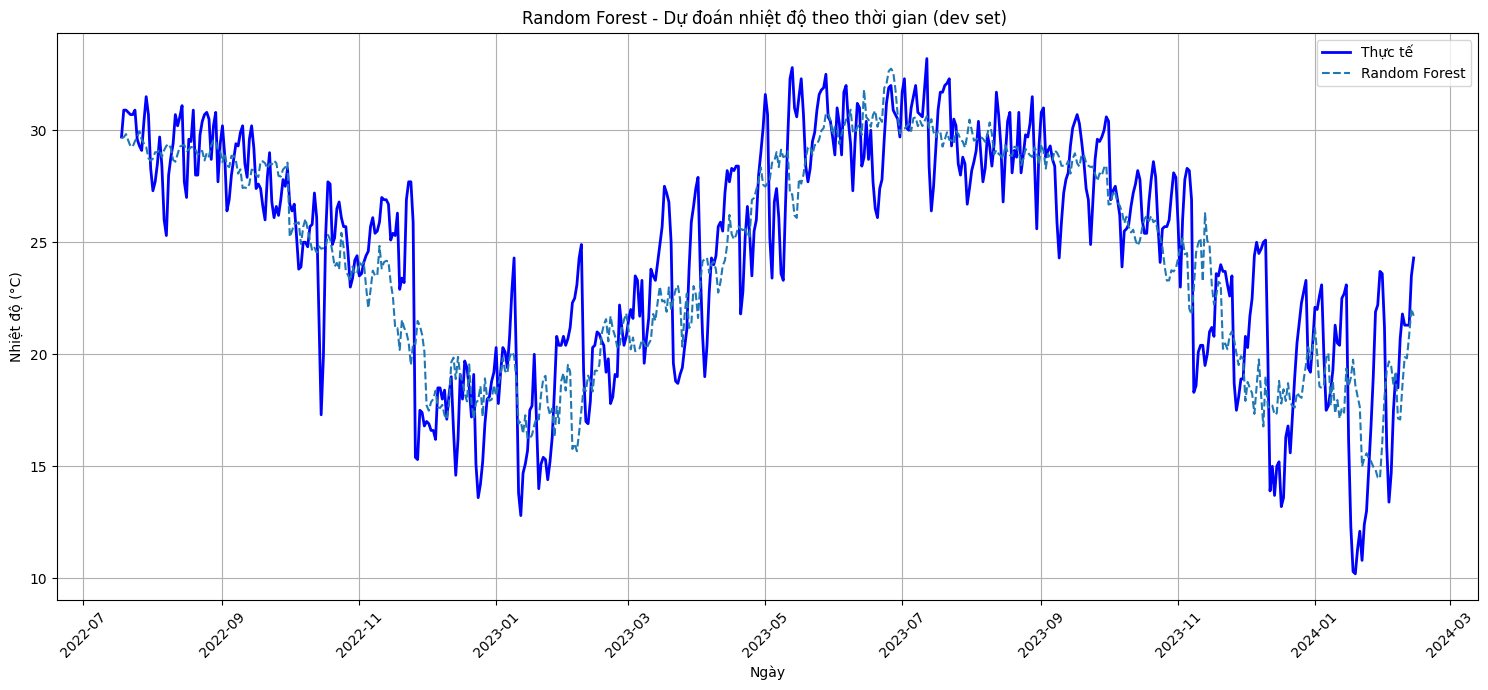

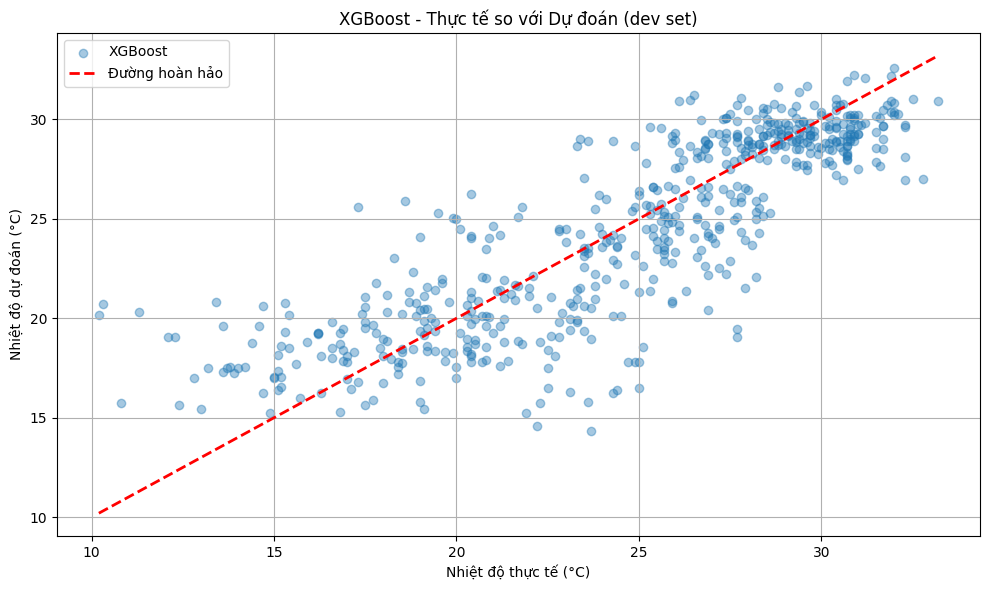

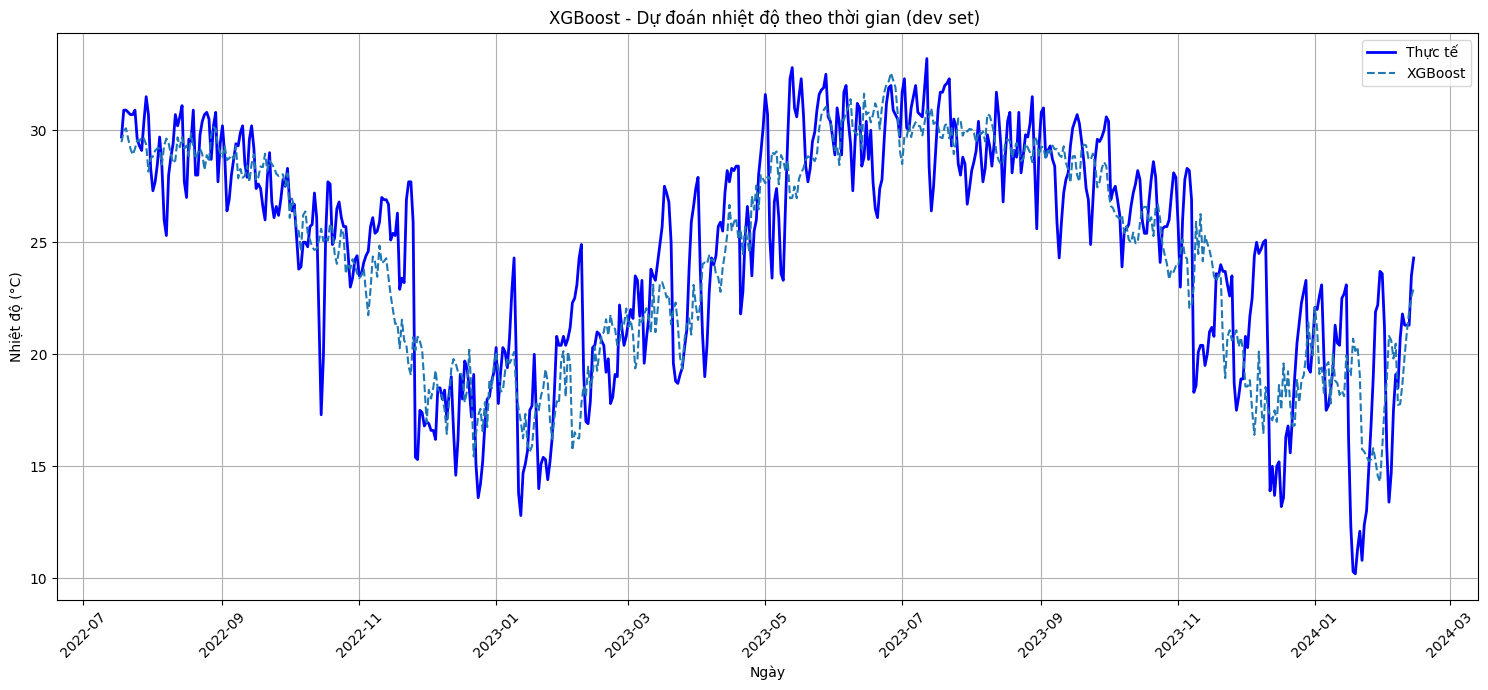


 Tổng hợp kết quả trên tập Development:
                      MAE     MSE    RMSE      R2
Linear Regression  1.9911  6.4840  2.5464  0.7505
Random Forest      2.1149  7.4971  2.7381  0.7115
XGBoost            2.1099  7.7476  2.7834  0.7019


In [8]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

def train_and_evaluate():
    """
    Loads data, trains Linear Regression, Random Forest, and XGBoost models,
    evaluates them on the development set, and visualizes the results.
    """
    # --- 1. Load Datasets ---
    try:
        X_train = pd.read_csv('C:/Users/lenovo/Downloads/python exercises/ml final 2/hanoi-weather-forecast/processed_data/X_train_transformed.csv', index_col='datetime', parse_dates=True)
        y_train = pd.read_csv('C:/Users/lenovo/Downloads/python exercises/ml final 2/hanoi-weather-forecast/processed_data/y_train.csv', index_col='datetime', parse_dates=True)

        X_dev = pd.read_csv('C:/Users/lenovo/Downloads/python exercises/ml final 2/hanoi-weather-forecast/processed_data/X_dev_transformed.csv', index_col='datetime', parse_dates=True)
        y_dev = pd.read_csv('C:/Users/lenovo/Downloads/python exercises/ml final 2/hanoi-weather-forecast/processed_data/y_dev.csv', index_col='datetime', parse_dates=True)

        X_test = pd.read_csv('C:/Users/lenovo/Downloads/python exercises/ml final 2/hanoi-weather-forecast/processed_data/X_test_transformed.csv', index_col='datetime', parse_dates=True)
        y_test = pd.read_csv('C:/Users/lenovo/Downloads/python exercises/ml final 2/hanoi-weather-forecast/processed_data/y_test.csv', index_col='datetime', parse_dates=True)
        
        print(" Tải dữ liệu thành công!")
    except FileNotFoundError as e:
        print(f" Lỗi: Không tìm thấy tệp. Vui lòng kiểm tra lại đường dẫn.")
        print(e)
        return

# --- 2. Initialize the model ---
    models = {
        "Linear Regression": LinearRegression(),
        "Random Forest": RandomForestRegressor(
            n_estimators=200, max_depth=12, min_samples_split=4, random_state=42, n_jobs=-1
        ),
        "XGBoost": XGBRegressor(
            n_estimators=300, max_depth=6, learning_rate=0.05,
            subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1
        )
    }

    # --- 3. Train và Evaluate ---
    results = {}
    for name, model in models.items():
        print(f"\n Huấn luyện mô hình: {name} ...")
        model.fit(X_train, y_train)
        print(f" Hoàn tất huấn luyện {name}!")

        y_dev_pred = model.predict(X_dev)

        mae = mean_absolute_error(y_dev, y_dev_pred)
        mse = mean_squared_error(y_dev, y_dev_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_dev, y_dev_pred)

        results[name] = {"MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2}

        print(f"\n--- Hiệu suất (dev set) ({name}) ---")
        print(f"  MAE:   {mae:.4f}")
        print(f"  MSE:   {mse:.4f}")
        print(f"  RMSE:  {rmse:.4f}")
        print(f"  R²:    {r2:.4f}\n")

    # --- 4. Visualization: Actual vs Predicted (Dev set) ---
    print("\n Đang tạo biểu đồ trực quan hóa số với dự đoán (dev set)...")

    for name, model in models.items():
        y_pred = model.predict(X_dev)

    # --- Scatter Plot ---
        plt.figure(figsize=(10, 6))
        plt.scatter(y_dev, y_pred, alpha=0.4, label=name)
        plt.plot([y_dev.min(), y_dev.max()], [y_dev.min(), y_dev.max()], 'r--', lw=2, label='Đường hoàn hảo')
        plt.title(f'{name} - Thực tế so với Dự đoán (dev set)')
        plt.xlabel('Nhiệt độ thực tế (°C)')
        plt.ylabel('Nhiệt độ dự đoán (°C)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # --- Line Plot ---
        plt.figure(figsize=(15, 7))
        plt.plot(y_dev.index, y_dev['target_temp_5d'], label='Thực tế', color='blue', linewidth=2)
        plt.plot(y_dev.index, y_pred, label=f'{name}', linestyle='--', linewidth=1.5)
        plt.title(f'{name} - Dự đoán nhiệt độ theo thời gian (dev set) ')
        plt.xlabel('Ngày')
        plt.ylabel('Nhiệt độ (°C)')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

   # --- 6. Summary of results ---
    print("\n Tổng hợp kết quả trên tập Development:")
    result_df = pd.DataFrame(results).T
    print(result_df.round(4))

if __name__ == '__main__':
    train_and_evaluate()
